In [1]:
import os
from glob import glob
import nibabel as nib
from scipy.spatial.distance import dice
import numpy as np
import itk
import SimpleITK as sitk
import scipy.ndimage
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm import threshold_stats_img

In [2]:
from nilearn.plotting import plot_design_matrix
mouses_filename = os.path.join('dataset2', 'Feminad', 'feminad.csv')
mouses_csv = pd.read_csv(mouses_filename)
male = mouses_csv['sex'] == 'M'
female = mouses_csv['sex'] == 'F'
age1 = mouses_csv['age'] == '2mois'
m2 = (male * age1)[:20]
f2 = (female * age1)[:20]

20


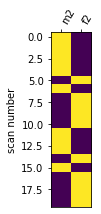

In [3]:
design_matrix = pd.DataFrame(np.vstack((m2, f2)).T,
                             columns=['m2', 'f2'])
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))

In [4]:
log_filenames = sorted(glob(os.path.join('output', 'Feminad', 'ANTS', 'Log10Jacobian_Deformable', "Log10JacobianDeformable_2*.nii.gz")))
print(len(log_filenames))
print(log_filenames)

20
['output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6516.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6517.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6518.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6519.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6520.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6521.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6522.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6523.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6524.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6528.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_2_6529.nii.gz', 'output/Feminad/ANTS/Log10Jacobian_Deformable/Log1

In [5]:
#atlas_mri = os.path.join('dataset2', 'Atlas', 'Norm_Atlas_MRI_128.nii.gz')
#mask_img = nib.load(os.path.join('dataset2', 'Atlas', 'Atlas_Mask_128.nii.gz'))
atlas_mri = os.path.join('dataset2', 'Atlas', 'Identity_Feminad_Template.nii.gz')
mask_img = nib.load(os.path.join('dataset2', 'Atlas', 'Identity_Feminad_Template_Mask.nii.gz'))
second_level_model = SecondLevelModel(smoothing_fwhm=0.5, mask_img=mask_img)
second_level_model.fit(log_filenames,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f31242dc190>,
                 smoothing_fwhm=0.5)

In [6]:
thresholds_dict = { 
                'fdr001': ('fdr', 0.01),
                'fpr001': ('fpr', 0.01),  
            }
contrasts_dict = {
    'sex'    : [-1, 1],
}

In [7]:
for heights, values in thresholds_dict.items():
    report = make_glm_report(model=second_level_model,
                             contrasts=contrasts_dict,
                             bg_img=atlas_mri,
                             height_control=values[0],
                             alpha=values[1],
                             display_mode='y',
                             cut_coords=128,
                             )
    report.save_as_html(os.path.join('output', 'Feminad', 'ANTS', 'Reports-Deformable', 'report_deformable_feminad_' + str(heights) + '.html'))

In [8]:
for k,v in contrasts_dict.items(): 
    z_map = second_level_model.compute_contrast(second_level_contrast=v, output_type='z_score')
    for heights, values in thresholds_dict.items():
        threshold_mask, threshold = threshold_stats_img(z_map, alpha=values[1], height_control=values[0])    
        nib.save(threshold_mask, os.path.join('output', 'Feminad', 'ANTS', 'Reports-Deformable', str(k) + '_' + str(heights) + '.nii.gz'))

In [9]:
print(z_map)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (128, 128, 128)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128 128   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'z_score of contrast [-1, 1]'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       

In [11]:
import os
import imageio as io


png_filenames = sorted(glob(os.path.join('output', 'Feminad', 'ANTS', 'Reports-Deformable', "*.png")))


for filename in png_filenames:    
    img = io.imread(filename)
    height, width, depth = img.shape
    width_cutoff = width // 2
    s1 = img[:, :width_cutoff]
    s2 = img[:, width_cutoff:]
    s3 = np.vstack((s1, s2))
    print(s3.shape)
    
    outname = filename.split(".")[0] + "_1.png"
    io.imwrite(outname, s3)

SyntaxError: broken PNG file (chunk b'\x00\x00\x00\x00') (<string>)